In [1]:
import torch, pyro, numpy as np

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

if not hasattr(torch.Tensor, '_numpy'):
    torch.Tensor._numpy = torch.Tensor.numpy
    torch.Tensor.numpy = lambda self: self.detach().cpu()._numpy()

In [2]:
from clipppy.yaml import MyYAML

fname = 'mockelt.yaml'
config = MyYAML().load(open(fname))

`config` is a `Clipppy` object with attributes:

  - `config._model`: the model from the YAML untouched
  - `config.model`: the possibly conditioned model, if conditioning was given in the YAML. So it may not be the same object as `_model`
  - `config.umodel`: is *always* unconditioned, even if an explicitly conditioned function was
      given as the `model` parameter to the `Clipppy` constructor

  - `config.guide`: the guide. an empty guide is automatically created that does nothing if nothing was specified in the YAML. Otherwise, it's still uninitialised until first run, i.e. need to either
call it like `config.guide()` or `config.guide.setup()` to gather information about parameters
and split them into groups, etc. Guides can be saved and loaded as any object using `torch.save` / `torch.load`, but beware to clean the pyro param store before loading, otherwise pyro will simply overwite any of the loaded attributes with values from the param store.... Clipppy will automatically assign the conditioned model to the guide in the initialiser, so this also needs to be done manually if loading a guide from file. (The model is not saved because sometimes it may be unpicklable.)

In [3]:
pyro.clear_param_store()
guide = config.guide = torch.load('mockelt-guide-gp.pt')
guide.model = config.model  # make sure you pass the conditioned model
guide.eval()  # turn off gradients
guide

Guide(
  (gp): DiagonalNormalSamplingGroup(2 sites, torch.Size([155540]))
  (lens): MultivariateNormalSamplingGroup(8 sites, torch.Size([8]))
)

Now one can draw samples from the posterior:

In [4]:
NPPD = 10
with pyro.plate('plate', NPPD):
    # This will give just NPPD parameter samples in a dictionary
    ppd = guide()
    # or to get NPPD full traces (actually a trace of batch shape NPPD) from the model
    ppd_traces = config.ppd()
    
# Now:
#   ppd = {'param': tensor with shape = (NPPD,) + intrinsic shape, ...}
#   ppd_traces = {
#     'guide_trace': trace from the guide, where the values are (10,) + intrinsic shape
#     'model_trace': trace from the model, where parameters were taken from the guide trace
#   }

For a simple range estimate, just draw a lot of samples and use the min/max

In [5]:
with pyro.plate('plate', 1000):
    constraints = {
        key: pyro.distributions.constraints.interval(val.min(axis=0)[0], val.max(axis=0)[0])
        for key, val in guide().items()
    }

In [6]:
torch.cuda.empty_cache()

One can do more sophisticated things, like for the GP parameters get n-sigma straightforwardly (because it's a diagonal normal):

In [7]:
nsigma = 5
lower = guide.gp.unpack(guide.gp.loc - nsigma * guide.gp.scale)
upper = guide.gp.unpack(guide.gp.loc + nsigma * guide.gp.scale)
constraints.update({key: pyro.distributions.constraints.interval(lower[key], upper[key]) for key in lower})

The `MultivariateNormalSamplingGroup` for the lens parameters has a `.scale_tril` parameter that can be used in a similar manner.

To create a constrained priors guide, one should iterate over the groups and use the information in `SamplingGoup.sites`. For example, to get all the priors:

In [8]:
priors = {
    key: site['fn']
    for group in guide.children()
    for key, site in group.sites.items()
}
priors

{'gp/alpha': Independent(Uniform(low: torch.Size([4]), high: torch.Size([4])), 1),
 'gp/theta': Independent(ExpandedDistribution(), 3),
 'ext/gamma_1': Normal(loc: 0.0, scale: 0.05000000074505806),
 'ext/gamma_2': Normal(loc: 0.0, scale: 0.05000000074505806),
 'main/phi': ExpandedDistribution(),
 'main/q': Uniform(low: 0.0, high: 1.0),
 'main/r_ein': Normal(loc: 1.0, scale: 0.5),
 'main/slope': Normal(loc: 2.0999999046325684, scale: 0.30000001192092896),
 'main/x': Normal(loc: -0.20000000298023224, scale: 0.10000000149011612),
 'main/y': Normal(loc: 0.0, scale: 0.10000000149011612)}

Then one can make an `InverseTransformDistribution` using the prior and the constrained range. A bit of care must be taken with batch and event dimensions. Basically, there should be no event dimensions (all dimensions must be independent to define a "range"), and the grid dimension should come first.

In [9]:
from pyrofit.core.utils import moveaxis
from pyrofit.lensing.new.distributions import InverseTransformDistribution

In [10]:
constrained_priors = {}

for key, ival in constraints.items():
    prior_ = priors[key]
    
    # gp layers are a single event in fitting, so get the un-to_event-ed distribution.
    if isinstance(prior_, pyro.distributions.Independent):
        prior = prior_.base_dist
    else:
        prior = prior_

    # torch.linspace doesn't seem to work with multi-dim arrays..., so imitate it:
    grid = moveaxis(
        (ival.lower_bound.unsqueeze(-1)
         + (ival.upper_bound-ival.lower_bound).unsqueeze(-1)
         * torch.linspace(0, 1, 201)),
        -1, 0)  # shape = (201,) + batch_shape
    
    constrained_priors[key] = InverseTransformDistribution(prior.log_prob, grid).to_event(len(prior_.event_shape))

In [11]:
constrained_priors

{'gp/alpha': Independent(InverseTransformDistribution(), 1),
 'gp/theta': Independent(InverseTransformDistribution(), 3),
 'ext/gamma_1': InverseTransformDistribution(),
 'ext/gamma_2': InverseTransformDistribution(),
 'main/phi': InverseTransformDistribution(),
 'main/q': InverseTransformDistribution(),
 'main/r_ein': InverseTransformDistribution(),
 'main/slope': InverseTransformDistribution(),
 'main/x': InverseTransformDistribution(),
 'main/y': InverseTransformDistribution()}

Finally, one has to make a guide that samples from these constrained priors, and this can be as simple as

In [12]:
def cp_guide(*args, exclude=(), **kwargs):
    return {
        key: pyro.sample(key, cp) for key, cp in constrained_priors.items()
        if key not in exclude
    }

Now let's check:

First set up some plotting

In [13]:
# For comparison with the posterior
with pyro.plate('plate', 1000):
    # when you draw from a group, the result is a tuple (unconstrained, {'param': constrained, ...})
    ppd_lens = guide.lens()[1]
with pyro.plate('plate', 100):  # fewer so as not to overflow the GPU memory
    ppd_source = guide.gp()[1]
    

from matplotlib import pyplot as plt

def plot_samples(samples):
    fig, axs = plt.subplots(3, 4, figsize=(15, 12), gridspec_kw=dict(hspace=0.3))

    for i, (ax, s) in enumerate(zip(axs[0], samples['gp/alpha'].t())):
        ax.hist(s, density=True)
        ax.hist(ppd_source['gp/alpha'][:, i], density=True, histtype='step')
        ax.set_xlabel(rf'$\alpha_{i}$')

    for ax, (key, s) in zip(axs[1:].flatten(), (item for item in samples.items() if item[0] != 'gp/alpha')):
        ax.hist(s, density=True)
        ax.hist(ppd_lens[key], density=True, histtype='step')

        # This is how to compare to the prior, but it's always very flat over the range anyway:
        # ax.plot(torch.sort(s)[0], priors[key].log_prob(torch.sort(s)[0]).exp() * 10)

        ax.set_xlabel(key)

    plt.tight_layout()

Check the guide itself:

/var/scratch/kkarchev/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


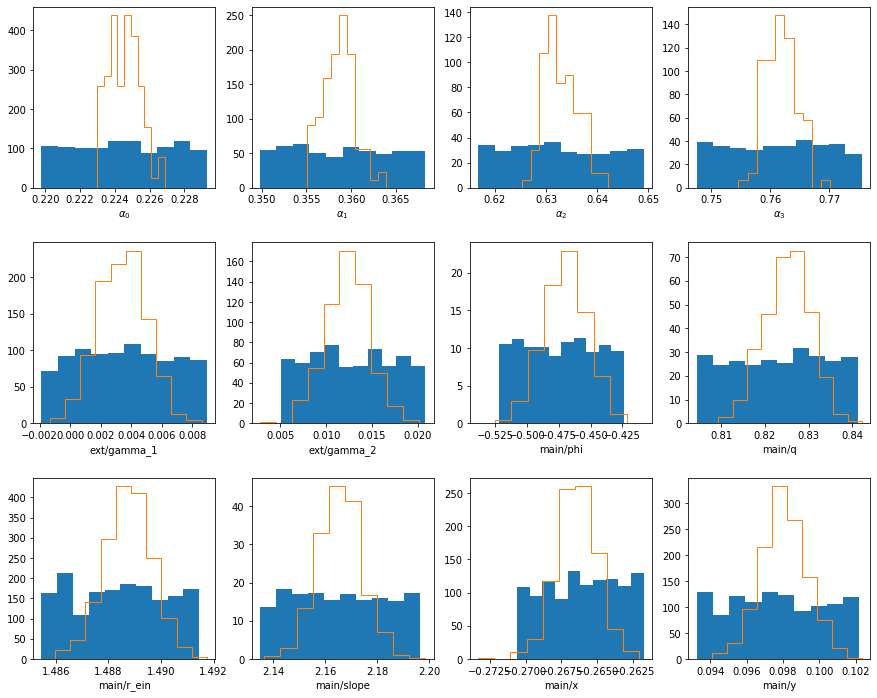

In [14]:
with pyro.plate('plate', 1000):
    samples = cp_guide(exclude=('gp/theta',))  # don't want to plot tons of parameters
plot_samples(samples)

Check that everything gets passed on correctly to the model:

/var/scratch/kkarchev/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


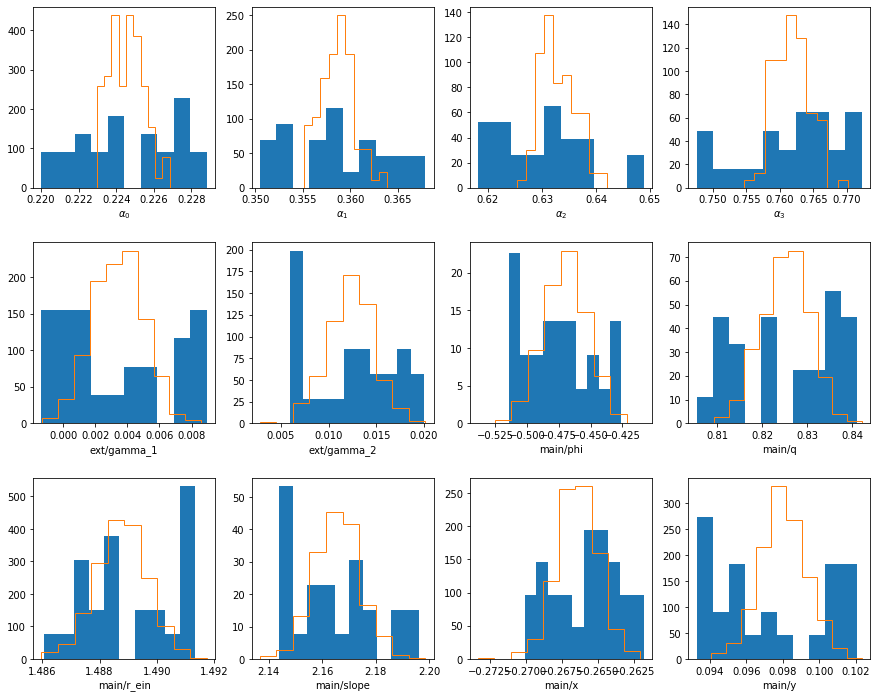

In [15]:
with pyro.plate('plate', 25):  # adjust this to avoid memory overflows
    ppd_traces = config.ppd(guide=cp_guide)

samples = {key: ppd_traces['model_trace'].nodes[key]['value']
           for key in constrained_priors if key != 'gp/theta'}

fig, axs = plt.subplots(3, 4, figsize=(15, 12), gridspec_kw=dict(hspace=0.3))

for i, (ax, s) in enumerate(zip(axs[0], samples['gp/alpha'].t())):
    ax.hist(s, density=True)
    ax.hist(ppd_source['gp/alpha'][:, i], density=True, histtype='step')
    ax.set_xlabel(rf'$\alpha_{i}$')

for ax, (key, s) in zip(axs[1:].flatten(), (item for item in samples.items() if item[0] != 'gp/alpha')):
    ax.hist(s, density=True)
    ax.hist(ppd_lens[key], density=True, histtype='step')
    
    # This is how to compare to the prior, but it's always very flat over the range anyway:
    # ax.plot(torch.sort(s)[0], priors[key].log_prob(torch.sort(s)[0]).exp() * 10)
    
    ax.set_xlabel(key)

plt.tight_layout()

Here's the average image and standard deviation to wrap up:

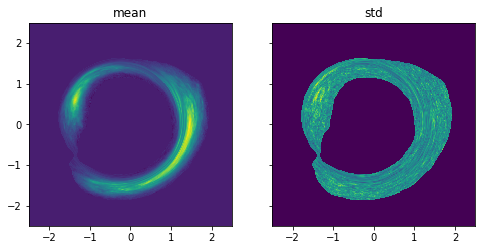

In [16]:
imkwargs = dict(origin='lower', extent=(-2.5, 2.5, -2.5, 2.5))
imgs = ppd_traces['model_trace'].nodes['mu']['value']

fig, axs = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(8, 5))
axs[0].imshow(imgs.mean(0), **imkwargs)
axs[0].set_title('mean')
axs[1].imshow(imgs.std(0), **imkwargs)
axs[1].set_title('std');